## Parameter optimization for KMeans Clustering of daily consumption patterns

In [3]:
import polars as pl
import glob
import numpy as np
import os
import logging
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
import itertools

logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation
from Hyperparameters_KMeans import optimize_kmeans



In [4]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d

Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [5]:
# Your data: numpy array of shape (n_samples, n_features)
X = train_data.squeeze()  # Adjust if 3D is (n_samples, n_timestamps, 1)

# Define grid of hyperparameters
param_grid = {
    'n_clusters': [3, 4, 5, 6, 7, 8],
    'init': ['k-means++', 'random'],
    'n_init': [1, 10, 20],
    'max_iter': [300, 500]
}


results = []

# Cartesian product of parameters
for n_clusters, init, n_init, max_iter in itertools.product(
    param_grid['n_clusters'],
    param_grid['init'],
    param_grid['n_init'],
    param_grid['max_iter']
):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init,
        n_init=n_init,
        max_iter=max_iter,
        random_state=42
    )
    labels = kmeans.fit_predict(X)
    # Calculate scores only if more than 1 cluster
    if len(set(labels)) > 1:
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        results.append({
            'n_clusters': n_clusters,
            'init': init,
            'n_init': n_init,
            'max_iter': max_iter,
            'silhouette_score': sil_score,
            'db_score': db_score
        })

# Results as a DataFrame, sorted by silhouette score (descending)
results_df = pd.DataFrame(results).sort_values(by='db_score', ascending=True)
print(results_df)

    n_clusters       init  n_init  max_iter  silhouette_score  db_score
17           4  k-means++      20       500          0.227061  1.346645
16           4  k-means++      20       300          0.227061  1.346645
15           4  k-means++      10       500          0.227061  1.346645
14           4  k-means++      10       300          0.227061  1.346645
23           4     random      20       500          0.226866  1.347196
..         ...        ...     ...       ...               ...       ...
68           8     random      10       300          0.159591  1.683878
69           8     random      10       500          0.159591  1.683878
71           8     random      20       500          0.159591  1.683878
60           8  k-means++       1       300          0.148199  1.687143
61           8  k-means++       1       500          0.148199  1.687143

[72 rows x 6 columns]


In [6]:
X = train_data.squeeze()  # adjust shape if needed

param_grid = {
    'n_clusters': np.arange(1, 11, 1), 
    #'init': ['k-means++', 'random'],
    'init': ['k-means++'],
    'n_init': np.arange(1, 6, 1), 
    'max_iter': np.arange(100, 600, 100), 
}

results = []

for n_clusters, init, n_init, max_iter in itertools.product(
    param_grid['n_clusters'],
    param_grid['init'],
    param_grid['n_init'],
    param_grid['max_iter']
):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init,
        n_init=n_init,
        max_iter=max_iter,
        random_state=42
    )
    labels = kmeans.fit_predict(X)
    if len(set(labels)) > 1:
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        results.append({
            'n_clusters': n_clusters,
            'init': init,
            'n_init': n_init,
            'max_iter': max_iter,
            'silhouette_score': sil_score,
            'db_score': db_score
        })

results_df = pd.DataFrame(results).sort_values(by='db_score', ascending=True)
print(results_df)

# Output best combination (highest silhouette score)
best_result = results_df.iloc[0]
print("\nBest combination of hyperparameters:")
print(best_result)

     n_clusters       init  n_init  max_iter  silhouette_score  db_score
65            4  k-means++       4       100          0.227061  1.346645
58            4  k-means++       2       400          0.227061  1.346645
59            4  k-means++       2       500          0.227061  1.346645
60            4  k-means++       3       100          0.227061  1.346645
61            4  k-means++       3       200          0.227061  1.346645
..          ...        ...     ...       ...               ...       ...
167           8  k-means++       4       300          0.148199  1.687143
168           8  k-means++       4       400          0.148199  1.687143
169           8  k-means++       4       500          0.148199  1.687143
153           8  k-means++       1       400          0.148199  1.687143
162           8  k-means++       3       300          0.148199  1.687143

[225 rows x 6 columns]

Best combination of hyperparameters:
n_clusters                  4
init                k-means++
n_

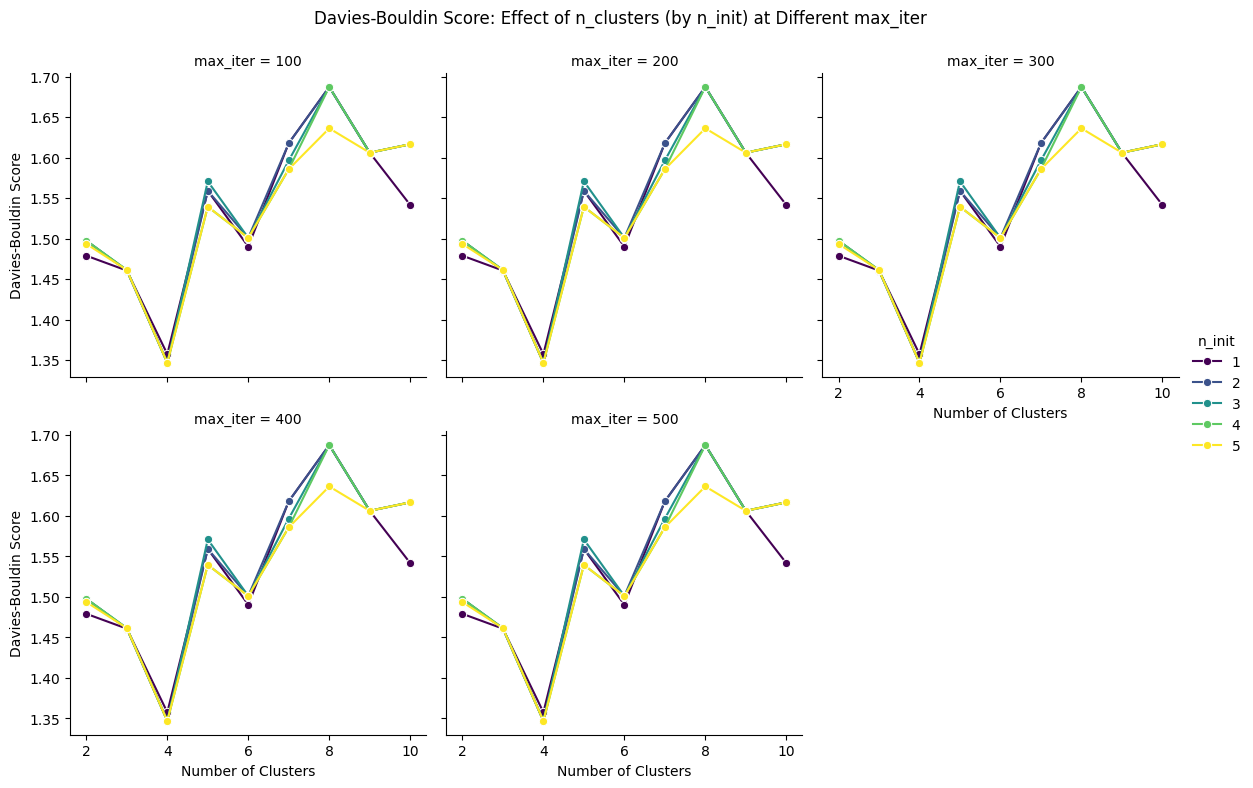

In [32]:
# Assuming results_df is your DataFrame with columns:
# 'n_clusters', 'n_init', 'max_iter', 'db_score'

# Example: Plot db_score vs n_clusters, colored by n_init, faceted by max_iter
g = sns.FacetGrid(results_df, col='max_iter', col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x='n_clusters', y='db_score', hue='n_init', marker='o', palette='viridis')

g.add_legend(title='n_init')
g.set_axis_labels('Number of Clusters', 'Davies-Bouldin Score')
g.set_titles(col_template='max_iter = {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Davies-Bouldin Score: Effect of n_clusters (by n_init) at Different max_iter')

plt.show()

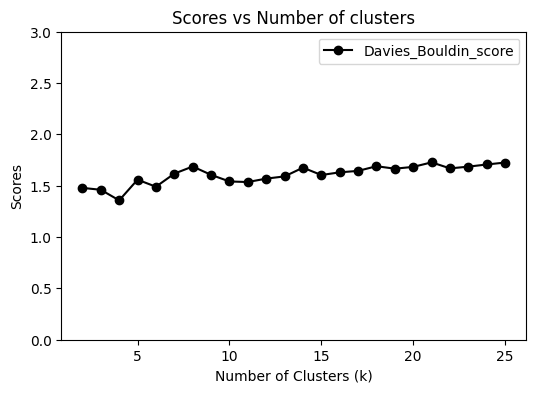

In [33]:
validation(train_data)

In [3]:
optimize_kmeans(train_data)


Best combination of hyperparameters:
n_clusters                  4
init                k-means++
n_init                      4
max_iter                  100
silhouette_score     0.227061
db_score             1.346645
Name: 65, dtype: object


n_clusters                  4
init                k-means++
n_init                      4
max_iter                  100
silhouette_score     0.227061
db_score             1.346645
Name: 65, dtype: object